In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import keras
from nltk.corpus import stopwords                
from nltk import word_tokenize, sent_tokenize
import re
# from nltk.stem import WordNetLemmatizer # 同义词转述
from nltk.stem import WordNetLemmatizer # 同义词转述

import keras
from keras import models
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,load_model
from keras.layers import Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional,Dropout
from keras.layers import Dropout , Activation, GRU, TimeDistributed,Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D,MaxPooling1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

from keras import backend as K

import gensim
from gensim.models import Word2Vec

from keras.engine.topology import Layer, InputSpec

from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
!ls '../input/'

glove6b100dtxt	kumarmanoj-bag-of-words-meets-bags-of-popcorn


In [3]:
import pandas as pd

df_x = pd.read_csv('../input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/labeledTrainData.tsv', delimiter="\t")
df_y = pd.read_csv('../input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/testData.tsv', delimiter="\t")
# df = df.drop(['id'], axis=1)
# print(df_x.head())
# print(df_y.head())

In [4]:
y = df_x['sentiment']
y.shape

(25000,)

In [5]:
df_x = df_x.drop(['sentiment'],axis = 1)
print(df_x.head())
print(df_y.head())

       id                                             review
0  5814_8  With all this stuff going down at the moment w...
1  2381_9  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3  The film starts with a manager (Nicholas Bell)...
3  3630_4  It must be assumed that those who praised this...
4  9495_8  Superbly trashy and wondrously unpretentious 8...
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...


In [6]:
df = pd.concat([df_x,df_y],ignore_index=True)
df.shape

(50000, 2)

In [7]:
import re
from nltk.stem import WordNetLemmatizer # 同义词转述
from nltk.corpus import stopwords # 删除停用词

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub(r"<br />", "", text) 
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if  (word not in stop_words)]
#     and(word!='<br />')
    text = " ".join(text)
    return text

df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))

In [8]:
df.to_excel('df_test.xls')
df['Processed_Reviews'].values[:2]

array(['stuff go moment mj ive start listen music watch odd documentary watch wiz watch moonwalker maybe want get certain insight guy think wa really cool eighty maybe make mind whether guilty innocent moonwalker part biography part feature film remember go see cinema wa originally release ha subtle message mjs feel towards press also obvious message drug bad mkaybr br visually impressive course michael jackson unless remotely like mj anyway go hate find bore may call mj egotist consent make movie mj fan would say make fan true really nice himbr br actual feature film bite finally start 20 minute exclude smooth criminal sequence joe pesci convince psychopathic powerful drug lord want mj dead bad beyond mj overhear plan nah joe pescis character rant want people know supply drug etc dunno maybe hate mjs musiclots cool thing like mj turn car robot whole speed demon sequence. also, director must patience saint come film kiddy bad sequence usually director hate work one kid let alone whole 

[0, 100)       26935
[100, 200)     15237
[200, 300)      4727
[300, 400)      1795
[400, 500)       857
[500, 600)       410
[600, 700)        22
[700, 800)         5
[900, 1000)        4
[800, 900)         4
dtype: int64


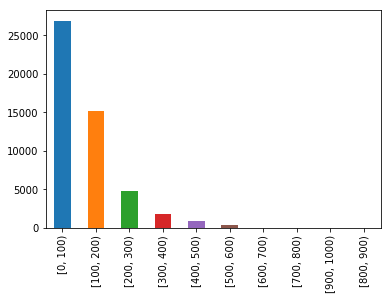

In [9]:
data_len = df.Processed_Reviews.apply(lambda x: len(x.split(" ")))

data_len_list = data_len.values.tolist()
# data_len_list
import matplotlib as plt

fenbu_list = [0,100,200,300,400,500,600,700,800,900,1000]
fenbu_cut = pd.cut(data_len_list,fenbu_list,right=False)
# print(fenbu_cut)
fenbu = pd.value_counts(fenbu_cut)
print(fenbu)

fenbu.plot(kind='bar')
# plt.xlabel('words_long_area')  
# plt.ylabel('counts') 
# plt.show()

In [10]:
max_features = 10000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])
word_index = tokenizer.word_index

maxlen = 300
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_t.shape

(50000, 300)

In [11]:
x_val = X_t[:5000]
y_val = y[:5000]
X_test = X_t[25000:]
X_t = X_t[5000:25000]
y = y[5000:]

In [12]:
print(x_val.shape)
print(y_val.shape)
print(X_t.shape)
print(y.shape)
print(X_test.shape)

(5000, 300)
(5000,)
(20000, 300)
(20000,)
(25000, 300)


In [13]:
import os
import numpy as np
EMBEDDING_DIM = 100

GLOVE_DIR = "../input/glove6b100dtxt/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [14]:
EMBEDDING_DIM = 100
maxlen = 300

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)

In [15]:
class AttLayer(Layer):
    def __init__(self, **kwargs):
        super(AttLayer, self).__init__(** kwargs)

    def build(self, input_shape):
        assert len(input_shape)==3
        # W.shape = (time_steps, time_steps)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[1], input_shape[1]),
                                 initializer='uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[1],),
                                 initializer='uniform',
                                 trainable=True)
        super(AttLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs.shape = (batch_size, time_steps, seq_len)
        x = K.permute_dimensions(inputs, (0, 2, 1))
        # x.shape = (batch_size, seq_len, time_steps)
        a = K.softmax(K.tanh(K.dot(x, self.W) + self.b))
        outputs = K.permute_dimensions(a * x, (0, 2, 1))
        outputs = K.sum(outputs, axis=1)
        return outputs

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

In [16]:
sequence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_gru = Bidirectional(GRU(100, dropout = 0.1, recurrent_dropout=0.1, return_sequences=True))(embedded_sequences)
l_att = AttLayer()(l_gru)
preds = Dense(1, activation='sigmoid')(l_att)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 100)          14582500  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300, 200)          120600    
_________________________________________________________________
att_layer_1 (AttLayer)       (None, 200)               90300     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 14,793,601
Trainable params: 14,793,601
Non-trainable params: 0
_________

In [17]:
print("model fitting - attention GRU network")
history = model.fit(X_t, y, validation_data=(x_val, y_val),nb_epoch=5, batch_size=128)

model fitting - attention GRU network
Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 126s 6ms/step - loss: 0.5580 - acc: 0.6979 - val_loss: 0.4252 - val_acc: 0.8110
Epoch 2/5
20000/20000 [==============================] - 119s 6ms/step - loss: 0.3577 - acc: 0.8466 - val_loss: 0.3271 - val_acc: 0.8564
Epoch 3/5
20000/20000 [==============================] - 123s 6ms/step - loss: 0.2806 - acc: 0.8836 - val_loss: 0.2741 - val_acc: 0.8892
Epoch 4/5
20000/20000 [==============================] - 119s 6ms/step - loss: 0.2405 - acc: 0.9041 - val_loss: 0.3231 - val_acc: 0.8628
Epoch 5/5
20000/20000 [==============================] - 121s 6ms/step - loss: 0.2114 - acc: 0.9148 - val_loss: 0.2605 - val_acc: 0.8974


In [18]:
model.save('model_1_w2v_simple.h5')

In [19]:
X_sub = X_test
y_pred = model.predict(X_sub)
# predictions = [1 if (x>0.5) else 0 for x in y_pred]
y_pred = y_pred.reshape(-1,)
predictions = pd.Series(y_pred)
# X_sub = X_test
# y_pred = model.predict(X_sub)
# predictions = [1 if (x>0.5) else 0 for x in y_pred]
# predictions = pd.Series(y_pred)
ids = df_y['id'].str.replace('"', '')
submission = pd.DataFrame({'id': ids, 'sentiment':predictions})
submission.to_csv('submission.csv',index=False)

y_preds = model.predict(x_val)
# x_stack = [1 if (x>0.5) else 0 for x in y_preds]
y_preds = y_preds.reshape(-1,)
x_stack = pd.Series(y_preds)

y_stack = pd.Series(y_val)
sub_stack = pd.DataFrame({'x_stack': x_stack, 'y_stack':y_stack})
sub_stack.to_csv('sub_stack.csv',index=False)